# Generate Honeycomb lattice

## Calculate site positions, bonds etc.

In [9]:
# if length(ARGS) < 1 error("L argument missing") end
# L=parse(Int, ARGS[1])
L = 4
N=L^2
nbonds = Int(4*N/2)

# nearest neighbor square lattice
sql = reshape(1:N, L, L)
up = circshift(sql,(-1,0))
right = circshift(sql,(0,-1))
down = circshift(sql,(1,0))
left = circshift(sql,(0,1))
neighbors = vcat(up[:]',right[:]',down[:]',left[:]') # colidx = site, rowidx = up right down left

# site positions
positions = Vector{Vector{Float64}}(N)
pi = 1
for x in 1:L
    for y in 1:L
        positions[pi] = [x, y]-1.0
        pi += 1
    end
end


# bonds
bonds = Vector{Vector{Int}}(nbonds) # from, to, type
bondvecs = Vector{Vector{Float64}}(nbonds) # to_pos - from_pos
ibond = 1
for site in 1:N
    up = neighbors[1,site]
    right = neighbors[2,site]
    
    # up bond
    bonds[ibond] = [site, up, 0]
    bondvecs[ibond] = [0, 1]
    ibond += 1
    
    # right bond
    bonds[ibond] = [site, right, 0]
    bondvecs[ibond] = [1, 0]
    ibond += 1
end

## Plot lattice

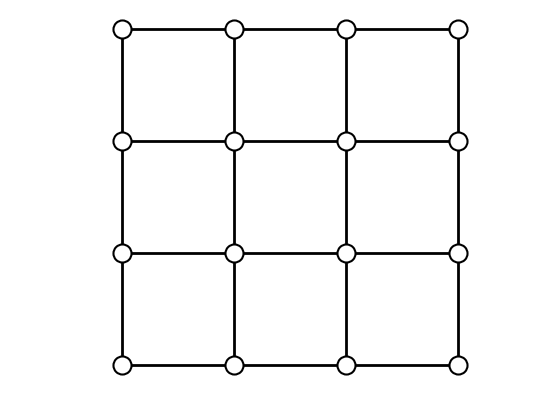

In [12]:
using PyPlot

# plot bonds
for (ibond, b) in enumerate(bonds)
    src = positions[b[1]]
    trg = positions[b[2]]
    
    # don't show pbc bonds
    b[2] > b[1] || continue
    b[2] - b[1] < 2*L || continue

    plot([src[1], trg[1]], [src[2], trg[2]], color="black", linewidth=2.0)
    gca()[:set_axis_off]()
end

# plot sites
for (s, pos) in enumerate(positions)
    plot(pos..., marker="o", markersize=13, color="white", mec="black", mew=1.5)
    
end
# scatter(getindex.(positions, 1), getindex.(positions, 2), c=1:length(positions), cmap="Blues")

axis("equal")
savefig("square_L_$(L)_W_$(L).pdf")

## Create ALPS like XML

In [17]:
using LightXML

# create an empty XML document
xdoc = XMLDocument()

# create & attach a graph (root) node
graph = create_root(xdoc, "GRAPH")
nedges = Int(4*N/2)
set_attributes(graph, dimension=2, vertices=N, edges=nedges)

function addvertex!(node, id, typ, coordinates)
    v = new_child(node, "VERTEX")
    set_attributes(v, Dict("id"=>id, "type"=>typ))

    vc = new_child(v, "COORDINATE")
    add_text(vc, "$(join(coordinates, " "))")
end

function addedge!(node, src, trg, id, typ, vector)
    edge = new_child(node, "EDGE")
    set_attributes(edge, id=id)
    set_attributes(edge, source=src, target=trg)
    set_attributes(edge, Dict("type"=>typ, "vector"=>join(vector, " ")))
end

# add vertices to graph
for (vi, pos) in enumerate(positions)
    addvertex!(graph, vi, 0, Int.(pos))
    
end

# add edges to graph
for (ibond, b) in enumerate(bonds)
    addedge!(graph, b[1], b[2], ibond, b[3], Int.(bondvecs[ibond]))
end

# s = string(xdoc);
# print(xdoc)

# save_file(xdoc, "square_L_$(L)_W_$(L).xml")
println("Done.")

Done.
